#Project - Tissue Segmentation on IBSR 18 dataset
Medical Image Segmentation and Application

**Pierpaolo Vendittelli, Abdullah Thabit, Prem Prasad**

*Universitat de Girona, Spain*

For this Notebook to run, First add the shared folder **MISA_FinalProject_Abdullah_Pierpaolo_Prem** to your Google Drive by right clicking on the folder and choosing "Add to my drive"

![](https://scontent-mxp1-1.xx.fbcdn.net/v/t1.0-9/12096563_522871731212414_7578645762495100106_n.jpg?_nc_cat=106&_nc_ohc=TM1Ii9lGFqUAQmpaOngYsEmYv_Y7SJa1XWpJs2i_5MSisAkDtE71cCg3g&_nc_ht=scontent-mxp1-1.xx&oh=e5271d359fe5f51b2a70983a38d2cedc&oe=5E6A391C)



# Dependencies and Architectures:

---
**Connecting with Drive, checking Directories, importing dependencies**



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive'
%cd 'MISA_FinalProject_Abdullah_Pierpaolo_Prem'

print('Importing Dependencies')
!pip install statsmodels
!pip install barbar
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/MISA_FinalProject_Abdullah_Pierpaolo_Prem
Importing Dependencies
     |████████████████████████████████| 255.7MB 65kB/s 


In [2]:
import os
import sys
import random
import ants
import logging
import torch
import numpy as np
import json
from utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader
from torch.optim import Adam
from utils import get_inference_patches, reconstruct_image
import pandas as pd
from metrics import DSC_seg, TPF_det, PPV_det
import nibabel as nib
import matplotlib.pyplot as plt
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from barbar import Bar

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


Create a folder to save the experiment's files

In [0]:
# -----------------------------
# create a folder for the experiment
# -----------------------------
tmpdir = "experiments"
if not (os.path.exists(tmpdir)):
    os.mkdir(tmpdir)

name = "experiment_checkCode"
tmpdir = os.path.join(tmpdir, name)
if not (os.path.exists(tmpdir)):
    os.mkdir(tmpdir)

## ResUnet

This Model is adapted from the work of Glioma Segmentation in https://github.com/karinvangarderen/glassimaging

<img src="https://www.researchgate.net/publication/335599509/figure/fig2/AS:799250594152448@1567567599628/Res-UNet-architecture-On-the-picture-left-side-the-residual-block-configurations.ppm" width="900" height="600" />



In [0]:
# -*- coding: utf-8 -*-

"""
3D with ResNet blocks
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResUNetBody(nn.Module):

    def __init__(self, k=16, outputsize=2, inputsize=4):
        super(ResUNetBody, self).__init__()
        self.outputsize = outputsize
        self.inputsize = inputsize
        self. k = k

        self.conv = ConvBlock(inputsize, k, 3)
        self.denseBlock1 = DenseBlock(n=2, inputsize=k)
        self.TD1 = TD(inputsize=k, outputsize=k*2)
        self.denseBlock2 = DenseBlock(n=2, inputsize=k*2)
        self.TD2 = TD(inputsize=k*2, outputsize=k*4)
        self.denseBlock3 = DenseBlock(n=2, inputsize=k*4)
        self.TD3 = TD(inputsize=k*4, outputsize=k * 4)
        self.denseBlock4 = DenseBlock(n=2, inputsize=k*4)
        self.TD4 = TD(inputsize=k*4, outputsize=k*4)
        self.denseBlockmid = DenseBlock(n=2, inputsize=k*4)
        self.UP1 = nn.ConvTranspose3d(k*4, k*4, 2, stride=2)
        self.denseBlock4_right = DenseBlock(n=2, inputsize=k*8)
        self.UP2 = nn.ConvTranspose3d(k*8, k*4, 2, stride=2)
        self.denseBlock3_right = DenseBlock(n=2, inputsize=k*8)
        self.UP3 = nn.ConvTranspose3d(k*8, k*2, 2, stride=2)
        self.denseBlock2_right = DenseBlock(n=2, inputsize=k*4)
        self.UP4 = nn.ConvTranspose3d(k*4, k*1, 2, stride=2)
        self.denseBlock1_right = DenseBlock(n=2, inputsize=k*2)

    def forward(self, x):
        res = self.conv(x)
        res = self.denseBlock1(res)
        skip1 = res.clone()
        res = self.TD1(res)
        res = self.denseBlock2(res)
        skip2 = res.clone()
        res = self.TD2(res)
        res = self.denseBlock3(res)
        skip3 = res.clone()
        res = self.TD3(res)
        res = self.denseBlock4(res)
        skip4 = res.clone()
        res = self.TD4(res)
        res = self.denseBlockmid(res)
        res = self.UP1(res)
        skip4 = skip4
        res = torch.cat([res, skip4], dim=1)
        res = self.denseBlock4_right(res)
        res = self.UP2(res)
        skip3 = skip3
        res = torch.cat([res, skip3], dim=1)
        res = self.denseBlock3_right(res)
        res = self.UP3(res)
        skip2 = skip2
        res = torch.cat([res, skip2], dim=1)
        res = self.denseBlock2_right(res)
        res = self.UP4(res)
        skip1 = skip1
        res = torch.cat([res, skip1], dim=1)
        res = self.denseBlock1_right(res)
        return res




class ResUNet(nn.Module):

    def __init__(self, k=16, outputsize=2, inputsize=4):
        super(ResUNet, self).__init__()
        self.outputsize = outputsize
        self.inputsize = inputsize
        self. k = k
        self.body = ResUNetBody(k=k, outputsize=outputsize, inputsize=inputsize)
        self.FC = ConvBlock(k*2, k*2, 1, padding=False)
        self.classifier = nn.Conv3d(k*2, self.outputsize, 1, padding=0)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        res = self.body(x)
        res = self.FC(res)
        res = self.classifier(res)
        res = self.softmax(res)
        return res


class DenseBlock(nn.Module):

    def __init__(self, k=10, n=4, inputsize=32, normgroups=1):
        super(DenseBlock, self).__init__()
        self.k = k
        self.n = n
        self.inputsize = inputsize
        self.convolutions = nn.ModuleList([nn.Conv3d(inputsize, inputsize, 3, padding=1) for _ in range(0, self.n)])
        self.groupNorm = nn.ModuleList([nn.GroupNorm(inputsize, inputsize) for _ in range(0, self.n)])
        self.dropout_dense = nn.Dropout3d(p=0.1)

    def forward(self, x):
        res = x
        for i in range(0, self.n):
            res = self.convolutions[i](res)
            res = self.groupNorm[i](res)
            res = F.leaky_relu(res)
            res = self.dropout_dense(res)
        res.add(x)
        return res

    def getOutputImageSize(self, inputsize):
        outputsize = [i - (self.n * 2) for i in inputsize]
        return outputsize


class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out, kernel_size, dropout=False, batchnorm=True, instancenorm=True,
                 padding=True):
        super(ConvBlock, self).__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.instancenorm = instancenorm
        if batchnorm:
            self.batchnorm_layer = nn.BatchNorm3d(channels_out)
        if padding:
            padding = 1
        else:
            padding = 0
        self.conv = nn.Conv3d(channels_in, channels_out, kernel_size, padding=padding)
        if dropout:
            self.dropout_layer = nn.Dropout3d(p=0.1)
        if instancenorm:
            self.instance_layer = nn.InstanceNorm3d(channels_in)

    def forward(self, x):
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm_layer(x)
        if self.instancenorm:
            x = self.instance_layer(x)
        x = F.leaky_relu(x)
        return x


class TD(nn.Module):

    def __init__(self, inputsize=32, outputsize=32):
        super(TD, self).__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.convolution = nn.Conv3d(self.inputsize, self.outputsize, 3, stride=2, padding=1)

    def forward(self, x):
        res = self.convolution(x)
        return res

    def getOutputImageSize(self, inputsize):
        outputsize = [i // 2 for i in inputsize]
        return outputsize

    def getOutputChannelSize(self):
        return self.k


##  U-NET: 
---

This Model is adapted from the Unet Seminar https://github.com/sergivalverde/MAIA_seminar

<img src="https://miro.medium.com/max/2640/1*J3t2b65ufsl1x6caf6GiBA.png" width="600" height="600" />
 

Let's now define our first patch-wise `Unet` model in PyTorch:

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size, dropout_rate=0.2):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        # batchNorm_dropout 1
        self.batchnorm1 = nn.InstanceNorm3d(32)
        self.dropout1 = nn.Dropout3d(p=dropout_rate)

        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        # batchNorm_dropout 2
        self.batchnorm2 = nn.InstanceNorm3d(64)
        self.dropout2 = nn.Dropout3d(p=dropout_rate)

        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        
        # batchNorm_dropout 3
        self.batchnorm3 = nn.InstanceNorm3d(128)
        self.dropout3 = nn.Dropout3d(p=dropout_rate)

        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        
        # batchNorm_dropout 4
        self.batchnorm4 = nn.InstanceNorm3d(256)
        self.dropout4 = nn.Dropout3d(p=dropout_rate)

        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1 = self.batchnorm1(x1)
        x1 = self.dropout1(x1)
        x1p = self.pool1(x1)

        x2 = F.relu(self.conv2(x1p))
        x2 = self.batchnorm2(x2)
        x2 = self.dropout2(x2)        
        x2p = self.pool2(x2)

        x3 = F.relu(self.conv3(x2p))
        x3 = self.batchnorm3(x3)
        x3 = self.dropout3(x3)
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))
        x4 = self.batchnorm4(x4)
        x4 = self.dropout4(x4)

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        return out

# 2. Data preparation:
---

Let's now obtain some data to train and test the model. Download the MRI scans and move it to `data`:

In [6]:
basedir = os.getcwd()
print('My current directory is: ', basedir)

My current directory is:  /content/drive/My Drive/MISA_FinalProject_Abdullah_Pierpaolo_Prem



Let's now train our `Unet` model using the `WMH2017` data. Before start training, several steps have to be taken into account: 
1. Split the available data into training, validation and test sets. 
2. Build the proper training data structures using the PyTorch `Dataset` and `Dataloader` objects.
3. Build the training loop. 

With the aim  to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values: 

## 2.2 Training generators: 

We are going to use the helper class `MRI_DataPatchLoader` from `utils.py` to generate a `Dataset` object based on our data. `MRI_DataPathLoader` requires an input dictionary with all image paths, image labels, and some other options for patch generation and normalization that we will cover in a few minutes. 

Additionally, the `MRI_DataPathLoader` also requires a third dictionary containing the paths a ROI mask from within the patch sampling should be performed. This mask is very handful to guide the sampling process, for instance to remove background voxels, deal with class imbalance etc...

For our example, let's generate a ROI mask for each subject simply with the binary brain mask:

In [0]:
options = {}

# training data path
options['training_path'] = 'data/Training_Set'

# validation data path
options['validation_path'] = 'data/Validation_Set'

# test data path
options['test_path'] = 'data/Test_Set'

# train/validation split percentage
options['train_split'] = 0.3

In [0]:
# -----------------------------
# create image roi masks
# -----------------------------

def mask_image(im):
  return (im > 0).astype('float32')


for scan_id in os.listdir(options['training_path']):
  scan = ants.image_read(os.path.join(options['training_path'], scan_id, '{}.nii.gz'.format(scan_id)))
  brainmask = ants.image_clone(scan).apply(mask_image)
  brainmask.to_filename(os.path.join(options['training_path'], scan_id, '{}_brainmask.nii.gz'.format(scan_id)))

for scan_id in os.listdir(options['validation_path']):
  scan = ants.image_read(os.path.join(options['validation_path'], scan_id, '{}.nii.gz'.format(scan_id)))
  brainmask = ants.image_clone(scan).apply(mask_image)
  brainmask.to_filename(os.path.join(options['validation_path'], scan_id, '{}_brainmask.nii.gz'.format(scan_id)))

Now, we can define the input dictionaries for training and validation: 

In [0]:
# -----------------------------
# load data
# -----------------------------

training_data = os.listdir(options['training_path'])
validation_data = os.listdir(options['validation_path'])

input_train_data = {scan: [os.path.join(options['training_path'], scan, '{}.nii.gz'.format(scan))]
                    for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, '{}_seg.nii.gz'.format(scan))]
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, '{}_brainmask.nii.gz'.format(scan))]
                    for scan in training_data}

input_val_data = {scan: [os.path.join(options['validation_path'], scan, '{}.nii.gz'.format(scan))]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['validation_path'], scan, '{}_seg.nii.gz'.format(scan))]
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['validation_path'], scan, '{}_brainmask.nii.gz'.format(scan))]
                  for scan in validation_data}


Build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. We [normalize](https://datascience.stackexchange.com/questions/32109/zero-mean-and-unit-variance) images with `mean=0` and `std=1`. In particular, we are going to use:

* Patch size of `32x32x32`
* Sampling step of `8x8x8`
* Batch size of `128`



In [10]:
# -----------------------------
# prepare patches and data loaders
# -----------------------------

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32,32,32)
options['sampling_step'] = (16,16,16)
options['normalize'] = True
options['batch_size'] = 128

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset,
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=options['batch_size'],
                                   shuffle=True)


Training data: 
> DATA: Loaded scan IBSR_16 roi size: 1460808 label_size:  1385945
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  787260
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  977824
> DATA: Loaded scan IBSR_18 roi size: 1668281 label_size:  1590195
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1027700
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  899576
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  950111
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  799514
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1093813
> DATA: Loaded scan IBSR_09 roi size: 1002429 label_size:  927415
> DATA: Training sample size: 2745
Validation data: 
> DATA: Loaded scan IBSR_11 roi size: 958119 label_size:  889996
> DATA: Loaded scan IBSR_17 roi size: 1565803 label_size:  1502254
> DATA: Loaded scan IBSR_14 roi size: 1140358 label_size:  1078981
> DATA: Loaded scan IBSR_13 roi size: 1058473 label_size:  1022741
> DA

In [0]:
def dice_loss(input, target):
  smooth = 1.
  total_loss =0
  n_classes = 4
  for c in range(n_classes):
          tflat = torch.flatten(target ==c)
          iflat = torch.flatten(input[:,c,:,:,:])


          intersection = torch.sum(iflat*tflat)
          #intersection = (iflat * tflat).sum()
          #print('intersection: ', intersection)
          a = (2. * intersection + smooth)
          #b = (iflat.sum() + tflat.sum() + smooth)
          
          #print('a: ',a,' b: ',b)
          loss = ( ((2. * intersection + smooth) /
                            (torch.sum(iflat) + torch.sum(tflat) + smooth)))
          #print(loss)
          if c ==0:
            total_loss = loss
          else:
            total_loss = total_loss + loss
  total_loss = total_loss / n_classes

  return 1-total_loss

# 3. Training the network:

---


Finally we can build our training loop to optimize the `Unet` model based on the same principles we covered in the first part of this tutorial. Basically, what we are going to do is to iterate the training dataset for a number of epochs, saving the weights of the model accordingly. 

For this first example, we are going to use the [cross-entropy](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) loss and the [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta) optimizer:



In [15]:
# -----------------------------
# Model training
# -----------------------------
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define the Unet model
# 2 input channels (FLAIR and T1)
# 2 output classes (healthy and wmh) (we ignore other pathologies)
# lesion_model = Unet(input_size=1, output_size=4)
lesion_model = ResUNet(outputsize=4, inputsize=1, k=16)

model_name = 'test_maia_wmh'

# some training options
options['gpu_use'] = True
options['num_epochs'] = 100
dice = False

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
optimizer = Adam(lesion_model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# send the model to the device
lesion_model = lesion_model.to(device)

# initialize accuracy and loss lists
train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []

# initialize best accuracy and loss
best_acc = 0.0
best_loss = 1e+5

# initialize the early_stopping counter
early_count = 0

# training loop
training = True
epoch = 1
try:
    since = time.time()
    while training:

        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0

        # -----------------------------
        # training samples
        # -----------------------------

        # set the model into train mode
        lesion_model.train()
        for b, batch in enumerate(Bar(training_dataloader)):
            # process batches: each batch is composed by training (x) and labels (y)
            # x = [32, 2, 32, 32, 32]
            # y = [32, 1, 32, 32, 32]

            x = batch[0].to(device)
            y = batch[1].to(device)

            # clear gradients
            optimizer.zero_grad()

            # infer the current batch
            pred = lesion_model(x)

            # compute the loss.
            # we ignore the index=2
            if dice:
              #print(pred.shape)
              #print(y.shape)
              loss = dice_loss(pred,y)
              train_loss += loss.item()
            else:
              loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                    y.squeeze(dim=1).long())
              train_loss += loss.item()

            # backward loss and next step
            loss.backward()
            optimizer.step()

            # compute the accuracy
            pred = pred.max(1, keepdim=True)[1]
            batch_accuracy = pred.eq(y.view_as(pred).long())
            train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))

        # -----------------------------
        # validation samples
        # -----------------------------

        # set the model into train mode
        lesion_model.eval()
        for a, batch in enumerate(Bar(validation_dataloader)):
            x = batch[0].to(device)
            y = batch[1].to(device)

            # infer the current batch
            with torch.no_grad():
                pred = lesion_model(x)

                # compute the loss.
                # we ignore the index=2
                if dice:
                  loss = dice_loss(pred, y)
                  train_loss += loss.item()
                else:
                  loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                    y.squeeze(dim=1).long())
                  val_loss += loss.item()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)

        # compute mean metrics
        train_loss /= (b + 1)
        train_accuracy /= (b + 1)
        val_loss /= (a + 1)
        val_accuracy /= (a + 1)

        train_loss_all.append(train_loss)
        train_acc_all.append(train_accuracy)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_accuracy)


        print('Epoch {:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
            epoch,
            train_loss,
            train_accuracy,
            val_loss,
            val_accuracy))
        
        if val_loss < best_loss:
              # save weights
              best_loss = val_loss
              best_acc = val_accuracy
              print("val loss decreased...saving model")
              best_model_wts = copy.deepcopy(lesion_model.state_dict()) #copy its weights
              model_path = "{}/model.pt".format(tmpdir)
              torch.save(lesion_model.state_dict(),model_path)
              early_count = 0
        else:
              early_count += 1

        # update epochs and lr
        epoch += 1
        scheduler.step(val_loss)
    
        if early_count == 10:
            print("Early stopping")
            training = False

        if epoch >= options['num_epochs']:
            training = False

    # load best model weights
    lesion_model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

except KeyboardInterrupt:
    pass

2745/2745: [==============================>.] - ETA 1.6s
1385/1385: [=============================>..] - ETA 0.6s
Epoch 1 train_loss 0.9991 train_acc 0.6751 val_loss 0.7483 val_acc 0.8069
val loss decreased...saving model
2745/2745: [==============================>.] - ETA 1.6s
1385/1385: [=============================>..] - ETA 0.6s
Epoch 2 train_loss 0.6943 train_acc 0.8202 val_loss 0.5698 val_acc 0.8586
val loss decreased...saving model
2745/2745: [==============================>.] - ETA 1.6s
1385/1385: [=============================>..] - ETA 0.6s
Epoch 3 train_loss 0.5597 train_acc 0.8524 val_loss 0.4746 val_acc 0.8767
val loss decreased...saving model
2745/2745: [==============================>.] - ETA 1.6s
1385/1385: [=============================>..] - ETA 0.6s
Epoch 4 train_loss 0.4796 train_acc 0.8662 val_loss 0.4101 val_acc 0.8869
val loss decreased...saving model
2745/2745: [==============================>.] - ETA 1.6s
1385/1385: [=============================>..] - ETA 0.6

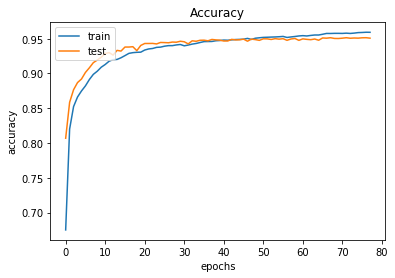

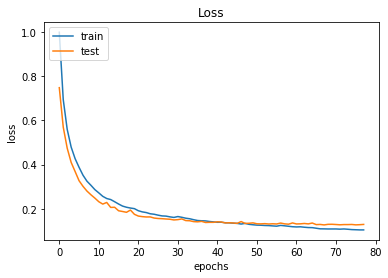

In [16]:
# training and val accuracy
plt.figure()
plt.plot(train_acc_all)
plt.plot(val_acc_all)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("{}/accuracy.png".format(tmpdir))

# training and val loss
plt.figure()
plt.plot(train_loss_all)
plt.plot(val_loss_all)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("{}/loss.png".format(tmpdir))

In [17]:
# -----------------------------
# Evaluation metrics on Training
# -----------------------------

# obtain a list of test scans
test_scans = os.listdir(options['training_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 3))
scan_id_list = []

for i, scan_name in enumerate(test_scans):

    scan_path = os.path.join(options['training_path'], scan_name)
    scan = ants.image_read(os.path.join(scan_path, '{}.nii.gz'.format(scan_name)))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                                       input_data=['{}.nii.gz'.format(scan_name)],
                                                       roi='{}_brainmask.nii.gz'.format(scan_name),
                                                       patch_shape=options['patch_size'],
                                                       step=options['sampling_step'],
                                                       normalize=options['normalize'])

    # lesion_out = np.zeros_like(infer_patches).astype('float32')
    lesion_out = np.zeros((infer_patches.shape[0], 4, infer_patches.shape[2], infer_patches.shape[3],
                           infer_patches.shape[4]), dtype='float32')
    batch_size = options['batch_size']

    # model evaluation
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b + batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b + batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob = np.expand_dims(reconstruct_image(lesion_out[:, 0],
                                                   coordenates,
                                                   scan.shape), axis=0)
    lesion_prob2 = np.expand_dims(reconstruct_image(lesion_out[:, 1],
                                                    coordenates,
                                                    scan.shape), axis=0)
    lesion_prob3 = np.expand_dims(reconstruct_image(lesion_out[:, 2],
                                                    coordenates,
                                                    scan.shape), axis=0)
    lesion_prob4 = np.expand_dims(reconstruct_image(lesion_out[:, 3],
                                                    coordenates,
                                                    scan.shape), axis=0)

    tissue_seg = np.stack((lesion_prob, lesion_prob2, lesion_prob3, lesion_prob4), axis=0).squeeze()

    tissue_seg = np.argmax(tissue_seg, axis=0)

    CSF = tissue_seg == 1
    GM = tissue_seg == 2
    WM = tissue_seg == 3

    # binarize the results
    lesion_prob = (lesion_prob > th).astype('uint8')

    # evaluate the results
    gt = ants.image_read(os.path.join(scan_path, '{}_seg.nii.gz'.format(scan_name)))
    dsc_CSF = DSC_seg(gt.numpy() == 1, CSF)
    dsc_GM = DSC_seg(gt.numpy() == 2, GM)
    dsc_WM = DSC_seg(gt.numpy() == 3, WM)
    # tpf_metric = TPF_det(gt.numpy() == 1, lesion_prob > 0)
    # ppv_metric = PPV_det(gt.numpy() == 1, lesion_prob > 0)

    metrics[i] = [dsc_CSF, dsc_GM, dsc_WM]
    scan_id_list.append(scan_name)

    print('SCAN:', scan_name, 'dice_CSF: ', dsc_CSF, 'dice_GM:', dsc_GM, 'dice_WM:', dsc_WM)

    # # save as nifti image is necessary
    seg_img = ants.from_numpy(tissue_seg.astype('uint8'))
    seg_img = ants.copy_image_info(scan, seg_img)
    # write segmented image to folder
    # seg_path = "{}/{}.nii.gz".format(tmpdir, scan_name)
    # ants.image_write(seg_img, seg_path)


# we use PANDAS to describe data :)
metrics_df = {'scan_id': scan_id_list, 'DSC_CSF': metrics[:, 0], 'DSC_GM': metrics[:, 1], 'DSC_WM': metrics[:, 2]}
m = pd.DataFrame(metrics_df, columns=['scan_id', 'DSC_CSF', 'DSC_GM', 'DSC_WM'])
m_mean = m.describe().T


diceAll_csv_path = "{}/dice_all_train.csv".format(tmpdir)
diceMean_csv_path = "{}/dice_mean_train.csv".format(tmpdir)
m.to_csv(diceAll_csv_path)
m_mean.to_csv(diceMean_csv_path)

# handlers = logger.handlers[:]
# for handler in handlers:
#     handler.close()
#     logger.removeHandler(handler)
m_mean

/content/drive/My Drive/MISA_FinalProject_Abdullah_Pierpaolo_Prem/utils.py:462: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_16 dice_CSF:  0.9273466649897287 dice_GM: 0.9751084937826228 dice_WM: 0.9718927441789565
SCAN: IBSR_08 dice_CSF:  0.9591064340441244 dice_GM: 0.9606802256921664 dice_WM: 0.9721165988860555
SCAN: IBSR_06 dice_CSF:  0.9455516653200466 dice_GM: 0.9560074171894481 dice_WM: 0.9626772756711033
SCAN: IBSR_18 dice_CSF:  0.9421988768603335 dice_GM: 0.9739324954091815 dice_WM: 0.9732470646682484
SCAN: IBSR_04 dice_CSF:  0.9121592909609665 dice_GM: 0.9668276963345883 dice_WM: 0.9616821658461524
SCAN: IBSR_03 dice_CSF:  0.9002175489485135 dice_GM: 0.9694142812578915 dice_WM: 0.9625484953477865
SCAN: IBSR_05 dice_CSF:  0.9377578078962876 dice_GM: 0.957521005530351 dice_WM: 0.9606489763982938
SCAN: IBSR_07 dice_CSF:  0.9400009607532306 dice_GM: 0.963715937516909 dice_WM: 0.9734246714832158
SCAN: IBSR_01 dice_CSF:  0.9485167850769386 dice_GM: 0.970478925526254 dice_WM: 0.9699822525906405
SCAN: IBSR_09 dice_CSF:  0.9570654138055656 dice_GM: 0.9599709036435264 dice_WM: 0.9661672929902316


,count,mean,std,min,25%,50%,75%,max
DSC_CSF,10.0,0.936992,0.018847,0.900218,0.929949,0.941100,0.947776,0.959106
DSC_GM,10.0,0.965366,0.006798,0.956007,0.960148,0.965272,0.970213,0.975108
DSC_WM,10.0,0.967439,0.005220,0.960649,0.962581,0.968075,0.972061,0.973425


# 5. Evaluation:
---

In order to evaluate the results, we use standard metric for lesion segmentation such as:
* `DSC:` Dice **segmentation** coefficient 

Let's infer all the test images and evaluate the results in average calculating the Dice Score for: 
* `CSF`
* `GM`
* `WM`

In [18]:
# -----------------------------
# Evaluation metrics
# -----------------------------

# obtain a list of test scans
test_scans = os.listdir(options['validation_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 3))
scan_id_list = []

for i, scan_name in enumerate(test_scans):

    scan_path = os.path.join(options['validation_path'], scan_name)
    scan = ants.image_read(os.path.join(scan_path, '{}.nii.gz'.format(scan_name)))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                                       input_data=['{}.nii.gz'.format(scan_name)],
                                                       roi='{}_brainmask.nii.gz'.format(scan_name),
                                                       patch_shape=options['patch_size'],
                                                       step=options['sampling_step'],
                                                       normalize=options['normalize'])

    # lesion_out = np.zeros_like(infer_patches).astype('float32')
    lesion_out = np.zeros((infer_patches.shape[0], 4, infer_patches.shape[2], infer_patches.shape[3],
                           infer_patches.shape[4]), dtype='float32')
    batch_size = options['batch_size']

    # model evaluation
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b + batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b + batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob = np.expand_dims(reconstruct_image(lesion_out[:, 0],
                                                   coordenates,
                                                   scan.shape), axis=0)
    lesion_prob2 = np.expand_dims(reconstruct_image(lesion_out[:, 1],
                                                    coordenates,
                                                    scan.shape), axis=0)
    lesion_prob3 = np.expand_dims(reconstruct_image(lesion_out[:, 2],
                                                    coordenates,
                                                    scan.shape), axis=0)
    lesion_prob4 = np.expand_dims(reconstruct_image(lesion_out[:, 3],
                                                    coordenates,
                                                    scan.shape), axis=0)

    tissue_seg = np.stack((lesion_prob, lesion_prob2, lesion_prob3, lesion_prob4), axis=0).squeeze()

    tissue_seg = np.argmax(tissue_seg, axis=0)

    CSF = tissue_seg == 1
    GM = tissue_seg == 2
    WM = tissue_seg == 3

    # binarize the results
    lesion_prob = (lesion_prob > th).astype('uint8')

    # evaluate the results
    gt = ants.image_read(os.path.join(scan_path, '{}_seg.nii.gz'.format(scan_name)))
    dsc_CSF = DSC_seg(gt.numpy() == 1, CSF)
    dsc_GM = DSC_seg(gt.numpy() == 2, GM)
    dsc_WM = DSC_seg(gt.numpy() == 3, WM)
    # tpf_metric = TPF_det(gt.numpy() == 1, lesion_prob > 0)
    # ppv_metric = PPV_det(gt.numpy() == 1, lesion_prob > 0)

    metrics[i] = [dsc_CSF, dsc_GM, dsc_WM]
    scan_id_list.append(scan_name)

    print('SCAN:', scan_name, 'dice_CSF: ', dsc_CSF, 'dice_GM:', dsc_GM, 'dice_WM:', dsc_WM)

    # # save as nifti image is necessary
    seg_img = ants.from_numpy(tissue_seg.astype('uint8'))
    seg_img = ants.copy_image_info(scan, seg_img)
    # write segmented image to folder
    seg_path = "{}/{}.nii.gz".format(tmpdir, scan_name)
    ants.image_write(seg_img, seg_path)


# we use PANDAS to describe data :)
metrics_df = {'scan_id': scan_id_list, 'DSC_CSF': metrics[:, 0], 'DSC_GM': metrics[:, 1], 'DSC_WM': metrics[:, 2]}
m = pd.DataFrame(metrics_df, columns=['scan_id', 'DSC_CSF', 'DSC_GM', 'DSC_WM'])
m_mean = m.describe().T


diceAll_csv_path = "{}/dice_all_val.csv".format(tmpdir)
diceMean_csv_path = "{}/dice_mean_val.csv".format(tmpdir)
m.to_csv(diceAll_csv_path)
m_mean.to_csv(diceMean_csv_path)
m_mean
# handlers = logger.handlers[:]
# for handler in handlers:
#     handler.close()
#     logger.removeHandler(handler)

/content/drive/My Drive/MISA_FinalProject_Abdullah_Pierpaolo_Prem/utils.py:462: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_11 dice_CSF:  0.9065187239944521 dice_GM: 0.9499878615991091 dice_WM: 0.9657157708022376
SCAN: IBSR_17 dice_CSF:  0.9463829447460875 dice_GM: 0.9542541697533219 dice_WM: 0.9407841476765385
SCAN: IBSR_14 dice_CSF:  0.9304174950298211 dice_GM: 0.9588580390995936 dice_WM: 0.9542128141452816
SCAN: IBSR_13 dice_CSF:  0.8986047357178567 dice_GM: 0.9476670918751977 dice_WM: 0.9333250145578571
SCAN: IBSR_12 dice_CSF:  0.9225724922299259 dice_GM: 0.9403830365381401 dice_WM: 0.9495068151852064


,count,mean,std,min,25%,50%,75%,max
DSC_CSF,5.0,0.920899,0.019017,0.898605,0.906519,0.922572,0.930417,0.946383
DSC_GM,5.0,0.950230,0.006968,0.940383,0.947667,0.949988,0.954254,0.958858
DSC_WM,5.0,0.948709,0.012446,0.933325,0.940784,0.949507,0.954213,0.965716
